In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import warnings
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder
)

from feature_engine.encoding import RareLabelEncoder
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from utils import eda_helper_functions
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.ensemble import IsolationForest
import sklearn

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import warnings

In [3]:
pd.set_option('display.max_columns',None)
sklearn.set_config(transform_output = "pandas")
warnings.filterwarnings("ignore")

In [4]:
from utils.feature_utils import (
    find_part_of_month,
    part_of_day,
    make_month_object,
    remove_duration,
    duration_category,
    is_same_region
)


In [5]:
training_data = pd.read_csv("../data/processed/train_data.csv")
X_train = training_data.drop(columns = ['price'])
y_train = training_data.price

testing_data = pd.read_csv("../data/processed/test_data.csv")
X_test = testing_data.drop(columns = ['price'])
y_test = testing_data.price

df1 = pd.DataFrame(y_train.to_list(),index = y_train.index,columns=['price'])
temp = pd.concat([X_train,df1],axis = 1)

temp["date"] = pd.to_datetime(temp.rename(columns={'dtoj_year': 'year', 
                                     'dtoj_month': 'month', 
                                     'dtoj_day': 'day'})[['year', 'month', 'day']])
temp.head(2)

,airline,source,destination,duration,total_stops,additional_info,dep_time_hour,dep_time_min,dtoj_day,dtoj_month,dtoj_year,route_key,price,date
0,Air Asia,kolkata,banglore,150,0,no info,19,55,6,5,2019,"('kolkata', 'banglore')",4409,2019-05-06
1,Jet Airways,delhi,cochin,450,1,in-flight meal not included,20,55,9,5,2019,"('delhi', 'cochin')",12373,2019-05-09


### Airline Feature Engineering

In [ ]:
airline_transformer = Pipeline(steps = [
    ("grouper",RareLabelEncoder(tol = 0.1,n_categories=2,replace_with="Other")),
    ("onehotencoding",OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])
airline_transformer.fit_transform(temp[["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
6689,0.0,0.0,1.0,0.0,0.0
6690,0.0,0.0,0.0,0.0,1.0
6691,1.0,0.0,0.0,0.0,0.0
6692,0.0,0.0,1.0,0.0,0.0


### Date_of_Journey

In [ ]:
dtoj_transformer = Pipeline(steps = [
    ("dt",DatetimeFeatures(features_to_extract = ['weekend'],yearfirst = True,format = "mixed"))
])

weekend = dtoj_transformer.fit_transform(temp[['date']])
temp = temp.assign(is_weekend = weekend)

temp.drop(columns=['dep_time_min'],inplace=True)

### Source and Destination

In [ ]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.rbf import RouteCreator

In [9]:
from feature_engine.encoding import MeanEncoder
from sklearn.pipeline import Pipeline

route_map = {
    ("delhi", "cochin"): "1",
    ("kolkata", "banglore"): "2",
    ("mumbai", "hyderabad"): "3",
    ("banglore", "new delhi"): "4",
    ("banglore", "delhi"): "5",
    ("chennai", "kolkata"): "6"
}

sor_des_trans = Pipeline(steps=[
    ("create_route", RouteCreator(route_map=route_map)),
    ("onehotencoding",OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

sor_des_trans.fit_transform(temp[['source','destination']], temp['price'])

,route_1,route_2,route_3,route_4,route_5,route_6
0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
6689,0.0,1.0,0.0,0.0,0.0,0.0
6690,0.0,1.0,0.0,0.0,0.0,0.0
6691,1.0,0.0,0.0,0.0,0.0,0.0
6692,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
temp.query("source == 'chennai' & destination == 'kolkata'").shape

(244, 14)

In [11]:
import numpy as np

north_cities = ['delhi', 'new delhi']

In [12]:
from sklearn.preprocessing import FunctionTransformer

north_cities = ['delhi','new delhi']

FunctionTransformer(func=is_same_region).fit_transform(temp[["source","destination"]])

,same_region
0,0
1,0
2,0
3,0
4,0
...,...
6689,0
6690,0
6691,0
6692,0


In [13]:
from sklearn.pipeline import FeatureUnion
source_destination_trans = FeatureUnion(transformer_list=[
    ("part1",sor_des_trans),
    ("part2",FunctionTransformer(func=is_same_region))
])

source_destination_trans.fit_transform(temp[['source','destination']],y = temp['price'])

,route_1,route_2,route_3,route_4,route_5,route_6,same_region
0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
6689,0.0,1.0,0.0,0.0,0.0,0.0,0
6690,0.0,1.0,0.0,0.0,0.0,0.0,0
6691,1.0,0.0,0.0,0.0,0.0,0.0,0
6692,0.0,1.0,0.0,0.0,0.0,0.0,0


## dep_time_hour

In [ ]:

dep_time_hour_union = FeatureUnion(transformer_list=[
    ('part1',FunctionTransformer(func=part_of_day)),
    ('part2',MinMaxScaler())
])


dep_time_hour_union.fit_transform(temp[['dep_time_hour']])

,part_of_day,dep_time_hour
0,16,0.826087
1,20,0.869565
2,20,0.869565
3,4,0.391304
4,16,0.695652
...,...,...
6689,16,0.739130
6690,16,0.739130
6691,16,0.739130
6692,20,0.869565


### dtoj_month and is_weekened feature engineering

In [ ]:
pipe3 = Pipeline(steps=[
    ("make_month_object",FunctionTransformer(func=make_month_object)),
    ("mean_encoding",MeanEncoder()),
    ("scaling",StandardScaler())
])


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

dtoj_month_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),  
    ('pca', PCA(n_components=1))  
])


dtoj_month_union = FeatureUnion(transformer_list=[
    ('part1',dtoj_month_transformer),
    ('part2',pipe3)
])

dtoj_month_union.fit_transform(temp[['dtoj_month','is_weekend']],y=temp['price'])

,pca0,dtoj_month
0,-0.295446,0.030754
1,-0.295446,0.030754
2,-0.295446,0.030754
3,-0.276353,1.223630
4,0.704144,0.030754
...,...,...
6689,-0.295446,0.030754
6690,0.723237,1.223630
6691,-0.295446,0.030754
6692,-0.295446,0.030754


### dtoj_day feature engineering

In [ ]:

pipe = Pipeline(steps = [
    ("part_of_month",FunctionTransformer(func=find_part_of_month)),
    ("encoding",MeanEncoder()),
    ("scaling",StandardScaler())
])


dtoj_day_union = FeatureUnion(transformer_list=[
    ("part1",pipe),
    ("part2",MinMaxScaler())
])
dtoj_day_union.fit_transform(temp[['dtoj_day']],y=temp['price'])

,part_of_month,dtoj_day
0,1.132333,0.192308
1,1.132333,0.307692
2,-1.075636,1.000000
3,-0.592890,0.423077
4,-0.592890,0.423077
...,...,...
6689,-1.075636,0.884615
6690,1.132333,0.307692
6691,-1.075636,0.769231
6692,1.132333,0.307692


### duration feature engineering

In [ ]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.rbf import RBFPercentileSimilarity


In [19]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(temp[['duration']])

,duration_rbf_40,duration_rbf_80
0,0.000000e+00,0.0
1,1.668157e-314,0.0
2,4.508027e-157,0.0
3,4.539993e-05,0.0
4,0.000000e+00,0.0
...,...,...
6689,0.000000e+00,0.0
6690,0.000000e+00,0.0
6691,0.000000e+00,0.0
6692,0.000000e+00,0.0


In [20]:
from feature_engine.outliers import Winsorizer

In [21]:
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(temp[['duration']])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration
0,-0.358991,-0.104749,-0.086624,0.0,-0.972589
1,-0.358991,-0.104749,-0.086624,2.0,-0.362963
2,-0.358991,-0.104749,-0.086624,1.0,-0.657615
3,-0.358991,-0.104749,-0.086624,1.0,-0.515369
4,-0.358991,-0.104749,-0.086624,0.0,-1.094514
...,...,...,...,...,...
6689,-0.358991,-0.104749,-0.086624,2.0,2.268588
6690,-0.358991,-0.104749,-0.086624,0.0,-0.972589
6691,-0.358991,-0.104749,-0.086624,2.0,1.892652
6692,-0.358991,-0.104749,-0.086624,2.0,0.490513


### duration and time_stops

In [22]:

numeric_transformer = Pipeline(steps=[
    ("scaling",StandardScaler()),
    ("pca",PCA(n_components=1))
])
    
pipe4 = Pipeline(steps=[
    ("remove_duration",FunctionTransformer(func=remove_duration))
])

total_stops_union = FeatureUnion(transformer_list=[
    ("part1",numeric_transformer),
    ("part2",pipe4)
])
total_stops_union.fit_transform(temp[['duration','total_stops']])

,pca0,total_stops,is_direct_flight
0,-1.545057,0,1
1,-0.047994,1,0
2,-0.254228,1,0
3,-0.154667,1,0
4,-1.630395,0,1
...,...,...,...
6689,1.793889,1,0
6690,-1.545057,0,1
6691,2.601135,2,0
6692,0.549374,1,0


### additional_info feature engineering

In [23]:
from utils.feature_utils import ToDataFrame

In [24]:

info_pipe1 = Pipeline(steps=[
    ("to_df", ToDataFrame(['additional_info'])),
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_pipe1)
])


info_transformer.fit_transform(temp[['additional_info']])

,additional_info_Other,additional_info_in-flight meal not included,additional_info_no info
0,0.0,0.0,1.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
6689,0.0,0.0,1.0
6690,0.0,0.0,1.0
6691,0.0,0.0,1.0
6692,0.0,1.0,0.0


In [25]:

X_train = X_train.assign(
    date = pd.to_datetime(X_train.rename(columns={'dtoj_year': 'year', 
                                     'dtoj_month': 'month', 
                                     'dtoj_day': 'day'})[['year', 'month', 'day']])
)
weekend = dtoj_transformer.fit_transform(X_train[['date']])
X_train = X_train.assign(is_weekend = weekend)
X_train.drop(columns = ['dep_time_min','dtoj_year','date'], inplace=True)
X_train.head(5)

,airline,source,destination,duration,total_stops,additional_info,dep_time_hour,dtoj_day,dtoj_month,route_key,is_weekend
0,Air Asia,kolkata,banglore,150,0,no info,19,6,5,"('kolkata', 'banglore')",0
1,Jet Airways,delhi,cochin,450,1,in-flight meal not included,20,9,5,"('delhi', 'cochin')",0
2,Indigo,delhi,cochin,305,1,no info,20,27,5,"('delhi', 'cochin')",0
3,Jet Airways,banglore,new delhi,375,1,no info,9,12,3,"('banglore', 'new delhi')",0
4,Indigo,mumbai,hyderabad,90,0,no info,16,12,5,"('mumbai', 'hyderabad')",1


In [26]:
X_test = X_test.assign(
    date = pd.to_datetime(X_test.rename(columns={'dtoj_year': 'year', 
                                     'dtoj_month': 'month', 
                                     'dtoj_day': 'day'})[['year', 'month', 'day']])
)
weekend = dtoj_transformer.fit_transform(X_test[['date']])
X_test = X_test.assign(is_weekend = weekend)
X_test.drop(columns = ['dep_time_min','dtoj_year','date'], inplace=True)
X_test.head(5)

,airline,source,destination,duration,total_stops,additional_info,dep_time_hour,dtoj_day,dtoj_month,route_key,is_weekend
0,Indigo,delhi,cochin,370,1,no info,16,6,3,"('delhi', 'cochin')",0
1,Multiple Carriers,delhi,cochin,920,1,no info,7,15,5,"('delhi', 'cochin')",0
2,Multiple Carriers,delhi,cochin,765,1,no info,9,27,5,"('delhi', 'cochin')",0
3,Jet Airways,kolkata,banglore,945,1,in-flight meal not included,16,1,4,"('kolkata', 'banglore')",0
4,Jet Airways,banglore,delhi,180,0,no info,19,24,6,"('banglore', 'delhi')",0


In [27]:
tuning_data = pd.read_csv("../data/processed/val_data.csv")
X_val = tuning_data.drop(columns = ['price'])
y_val = tuning_data.price

X_val = X_val.assign(
    date = pd.to_datetime(X_val.rename(columns={'dtoj_year': 'year', 
                                     'dtoj_month': 'month', 
                                     'dtoj_day': 'day'})[['year', 'month', 'day']])
)
weekend = dtoj_transformer.fit_transform(X_val[['date']])
X_val = X_val.assign(is_weekend = weekend)
X_val.drop(columns = ['dtoj_year','dep_time_min','date'],inplace = True)
X_val.head(5)

,airline,source,destination,duration,total_stops,additional_info,dep_time_hour,dtoj_day,dtoj_month,route_key,is_weekend
0,Indigo,mumbai,hyderabad,90,0,no info,21,27,5,"('mumbai', 'hyderabad')",0
1,Multiple Carriers,delhi,cochin,780,1,no info,8,21,3,"('delhi', 'cochin')",0
2,Indigo,kolkata,banglore,170,0,no info,5,24,3,"('kolkata', 'banglore')",1
3,Air India,banglore,delhi,170,0,no info,21,9,5,"('banglore', 'delhi')",0
4,Multiple Carriers,delhi,cochin,600,1,no info,9,24,6,"('delhi', 'cochin')",0


### ColumnTransformer

In [28]:
from sklearn.preprocessing import MinMaxScaler
column_transformer = ColumnTransformer( transformers =[
    ("tf1",airline_transformer,["airline"]), # Airline 
    ("tf3",source_destination_trans,["source","destination"]), # Source,destination
    ("tf4",dtoj_day_union,['dtoj_day']), 
    ("tf5",dep_time_hour_union,['dep_time_hour']), # part of day and scaled dep_time_hour 
    ("tf6",dtoj_month_union,['dtoj_month','is_weekend']),
    ("tf7",total_stops_union,['duration','total_stops']),
    ("tf8",duration_transformer,['duration']),
    ("tf9",info_transformer,['additional_info'])
],remainder="drop")
column_transformer.fit(X_train,y_train)

ColumnTransformer(transformers=[('tf1',
                                 Pipeline(steps=[('grouper',
                                                  RareLabelEncoder(n_categories=2,
                                                                   replace_with='Other',
                                                                   tol=0.1)),
                                                 ('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['airline']),
                                ('tf3',
                                 FeatureUnion(transformer_list=[('part1',
                                                                 Pipeline(steps=[('create_route',
                                                                                  RouteCreator(route_map={('banglore', 'delhi'): '5',...
                                 ['duration']),
                                ('tf9',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant')),
                                                 ('union',
                                                  Pipeline(steps=[('to_df',
                                                                   ToDataFrame(columns=['additional_info'])),
                                                                  ('group',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]))]),
                                 ['additional_info'])])

In [29]:
# Saving the Column Transformer

import os
import joblib

save_path = os.path.join("..", "artifacts", "latest_column_transformer.joblib")

joblib.dump(column_transformer, save_path)

print(f"✅ latest_column_transformer saved as {save_path}")


✅ latest_column_transformer saved as ..\artifacts\latest_column_transformer.joblib


In [30]:
# Transforming the training data to train the model

X_train_transformed = column_transformer.transform(X_train)
X_test_transformed = column_transformer.transform(X_test)
X_val_transformed = column_transformer.transform(X_val)

# Saving

os.makedirs(os.path.join("..", "transformed_data"), exist_ok=True)
train_path = os.path.join("..", "transformed_data", "X_train_transformed.csv")
test_path = os.path.join("..", "transformed_data", "X_test_transformed.csv")
val_path = os.path.join("..", "transformed_data", "X_val_transformed.csv")

X_train_transformed.to_csv(train_path, index=False)
X_test_transformed.to_csv(test_path, index=False)
X_val_transformed.to_csv(val_path, index=False)

print("✅ Transformed data saved to 'transformed_data/' folder.")

✅ Transformed data saved to 'transformed_data/' folder.


### Feature Selection

In [141]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=8, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.1
) 

In [142]:
preprocessor = Pipeline(steps=[
    ("ct", column_transformer),
    ("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,tf1__airline_Indigo,tf1__airline_Jet Airways,tf1__airline_Other,tf3__route_5,tf7__pca0,tf7__total_stops,tf7__is_direct_flight,tf8__duration_rbf_25,tf8__duration_cat,tf8__duration
0,0.0,0.0,1.0,0.0,-1.545057,0,1,-0.358991,0.0,-0.972589
1,0.0,1.0,0.0,0.0,-0.047994,1,0,-0.358991,2.0,-0.362963
2,1.0,0.0,0.0,0.0,-0.254228,1,0,-0.358991,1.0,-0.657615
3,0.0,1.0,0.0,0.0,-0.154667,1,0,-0.358991,1.0,-0.515369
4,1.0,0.0,0.0,0.0,-1.630395,0,1,-0.358991,0.0,-1.094514
...,...,...,...,...,...,...,...,...,...,...
6689,0.0,1.0,0.0,0.0,1.793889,1,0,-0.358991,2.0,2.268588
6690,0.0,0.0,1.0,0.0,-1.545057,0,1,-0.358991,0.0,-0.972589
6691,0.0,0.0,0.0,0.0,2.601135,2,0,-0.358991,2.0,1.892652
6692,0.0,1.0,0.0,0.0,0.549374,1,0,-0.358991,2.0,0.490513


In [143]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'tf5__part_of_day': np.float64(-0.0014195418078026822),
 'tf3__same_region': np.float64(-0.00021113992979230703),
 'tf9__additional_info_no info': np.float64(-0.00016306392229995895),
 'tf3__route_2': np.float64(0.0006487476492555988),
 'tf8__duration_rbf_75': np.float64(0.0007088488721975391),
 'tf9__additional_info_in-flight meal not included': np.float64(0.0010845752384104717),
 'tf1__airline_Air India': np.float64(0.003542914876409564),
 'tf8__duration_rbf_50': np.float64(0.0036251322329445834),
 'tf9__additional_info_Other': np.float64(0.01646629375975032),
 'tf5__dep_time_hour': np.float64(0.02104920738560741),
 'tf1__airline_Multiple Carriers': np.float64(0.022432625640153248),
 'tf4__part_of_month': np.float64(0.02350272686093306),
 'tf4__dtoj_day': np.float64(0.027759673550875164),
 'tf3__route_6': np.float64(0.032721134370852965),
 'tf3__route_4': np.float64(0.03735803477504814),
 'tf3__route_3': np.float64(0.05260342489618142),
 'tf3__route_1': np.float64(0.0649706059286711

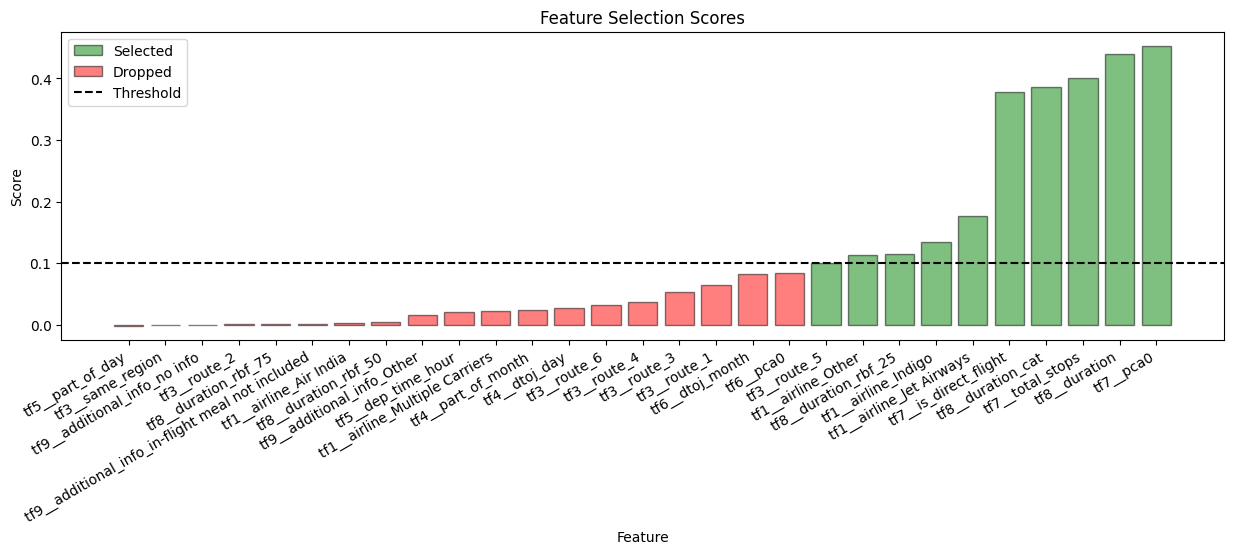

In [144]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
    params = dict(
        x=i,
        height=score,
        edgecolor="black",
        alpha=0.5
    )

    if score < THRESHOLD:
        bar = ax.bar(
            color="red",
            **params
        )
        if not dropped_bar:
            dropped_bar = bar[0]
    else:
        bar = ax.bar(
            color="green",
            **params
        )
        if not selected_bar:
            selected_bar = bar[0]

thresh_line = ax.axhline(
    y=0.1,
    color="black",
    linestyle="--"
)

ax.set_xticks(
    ticks=range(len(sorted_feat_imp)),
    labels=list(sorted_feat_imp.keys()),
    rotation=30,
    ha="right"
)

ax.set(
    xlabel="Feature",
    ylabel="Score",
    title="Feature Selection Scores"
)

ax.legend(
    handles=[selected_bar, dropped_bar, thresh_line],
    labels=["Selected", "Dropped", "Threshold"],
    loc="upper left"
)

plt.show()
